In [3]:
#the packages that we need
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [7]:
df = pd.read_csv('cleaned_kidney_disease - cleaned_kidney_disease.csv')

In [10]:
df = df.drop("Unnamed: 0", axis = 1)
df

,age,sg,su,pc,pcc,ba,bgr,bu,sc,sod,...,cad,appet,pe,ane,classification,al_0.0,al_1.0,al_2.0,al_3.0,al_4.0
0,48.0,1.020,0.0,1,0,0,121.0,36.0,1.2,138.829091,...,0,1,0,0,1,0,1,0,0,0
1,51.0,1.010,0.0,1,0,0,106.0,26.0,1.4,138.829091,...,0,1,0,0,1,0,0,1,0,0
2,60.0,1.015,0.0,1,0,0,74.0,25.0,1.1,142.000000,...,0,1,1,0,1,0,0,0,1,0
3,52.0,1.015,0.0,0,1,0,138.0,60.0,1.9,138.829091,...,0,1,0,1,1,0,0,0,1,0
4,53.0,1.020,0.0,0,1,0,70.0,107.0,7.2,114.000000,...,0,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,55.0,1.020,0.0,1,0,0,140.0,49.0,0.5,150.000000,...,0,1,0,0,0,1,0,0,0,0
342,42.0,1.025,0.0,1,0,0,75.0,31.0,1.2,141.000000,...,0,1,0,0,0,1,0,0,0,0
343,12.0,1.020,0.0,1,0,0,100.0,26.0,0.6,137.000000,...,0,1,0,0,0,1,0,0,0,0
344,17.0,1.025,0.0,1,0,0,114.0,50.0,1.0,135.000000,...,0,1,0,0,0,1,0,0,0,0


In [11]:
#Split into train, test, validation
y = df.loc[:, 'classification']
xcols = list(df.columns.values)
xcols.remove('classification')
x = df.loc[:, xcols]

x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle = True, test_size = 0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, shuffle = True, test_size = 0.1)

In [12]:
#Build the Pipeline
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('pca', PCA()),
                 ('svc', SVC())])

In [20]:
#Select Values to Grid Search Over
params = {'pca__n_components': np.random.randint(1, len(xcols), 3),
          'svc__C': [10**-3, 1, 10**3],
          'svc__coef0': [0, 1],
          'svc__max_iter': [-1, 10000000],
          'svc__kernel': ['poly', 'sigmoid', 'rbf'],
          'svc__gamma': [1/(len(df) - 1), 1/len(df), 1/(len(df) + 1)],
          'svc__degree': np.random.randint(1, 6, 3)}

In [21]:
#Grid Search over our Parameter Grid
grid_search = GridSearchCV(pipe, params)
grid_search.fit(x_val, y_val)

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('pca', PCA()), ('svc', SVC())]),
             param_grid={'pca__n_components': array([ 2,  9, 13]),
                         'svc__C': [0.001, 1, 1000], 'svc__coef0': [0, 1],
                         'svc__degree': array([1, 2, 3]),
                         'svc__gamma': [0.002898550724637681,
                                        0.002890173410404624,
                                        0.002881844380403458],
                         'svc__kernel': ['poly', 'sigmoid', 'rbf'],
                         'svc__max_iter': [-1, 10000000]})

In [22]:
#Get the Best Parameters
grid_search.best_params_

{'pca__n_components': 2,
 'svc__C': 1000,
 'svc__coef0': 0,
 'svc__degree': 1,
 'svc__gamma': 0.002898550724637681,
 'svc__kernel': 'poly',
 'svc__max_iter': -1}

In [23]:
#MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)

In [28]:
#PCA
pca = PCA(n_components = 2)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)

In [31]:
#SVC
svc = SVC(C = 1000, coef0 = 1, degree = 1, gamma = 0.002898550724637681, kernel = 'poly', max_iter = -1)
svc.fit(x_train_pca, y_train)

SVC(C=1000, coef0=1, degree=1, gamma=0.002898550724637681, kernel='poly')

In [34]:
#Get Testing Data in Correct Formt for Prediction
scaler = MinMaxScaler()
scaler.fit(x_test)
x_test_scaler = scaler.transform(x_test)
pca = PCA(n_components = 2)
pca.fit(x_test_scaler)
x_test_pca = pca.transform(x_test_scaler)

In [35]:
#Get Predictions
y_train_pred = svc.predict(x_train_pca)
y_test_pred = svc.predict(x_test_pca)

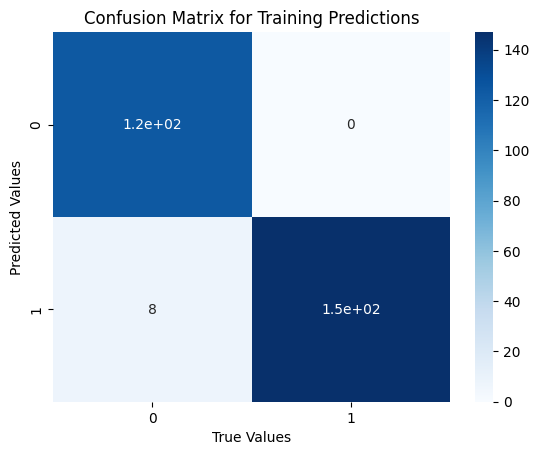

In [40]:
#Confusion Matric for Training
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
con_mat_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(con_mat_train, cmap = 'Blues', annot = True)
plt.title("Confusion Matrix for Training Predictions")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

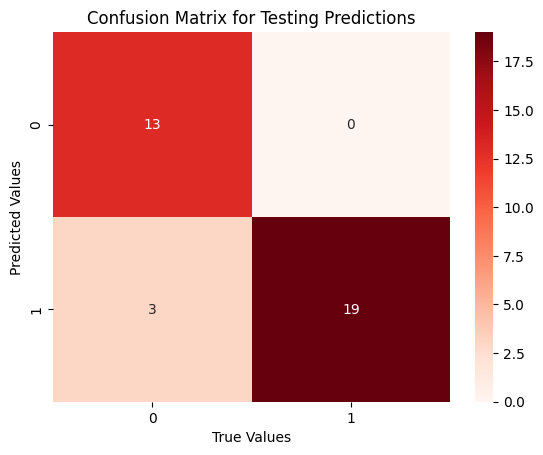

In [42]:
#Confusion Matric for Testing
con_mat_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(con_mat_test, cmap = 'Reds', annot = True)
plt.title("Confusion Matrix for Testing Predictions")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

In [48]:
#Accuracy Training
acc_train = (con_mat_train[0][0] + con_mat_train[1][1]) / (con_mat_train[0][0] + con_mat_train[0][1] + con_mat_train[1][0] + con_mat_train[1][1])
print(acc_train)

0.9713261648745519


In [50]:
#Accuracy Testing
acc_test = (con_mat_test[0][0] + con_mat_test[1][1]) / (con_mat_test[0][0] + con_mat_test[0][1] + con_mat_test[1][0] + con_mat_test[1][1])
print(acc_test)

0.9142857142857143
